# Leaf Disease Detection Project (Corn Model)

## Importing Required Libraries 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.preprocessing import image

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

## Defining Image Size, Batch Size and Colour Channels

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3

## Mounting GDrive as the Dataset is uploaded on personal Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the Dataset

In [ ]:
corn_train_tf = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/LDD/corn/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/LDD/corn/test",
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size =BATCH_SIZE, label_mode = 'int')

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/LDD/corn/val",
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size =BATCH_SIZE, label_mode = 'int')



Found 3809 files belonging to 4 classes.
Found 440 files belonging to 4 classes.
Found 435 files belonging to 4 classes.


In [ ]:
class_names_corn = test_dataset.class_names
class_names_corn

['Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___Northern_Leaf_Blight',
 'Corn___healthy']

In [ ]:
num_corn = len(test_dataset.class_names)
num_corn

4

## Visualizing the Data

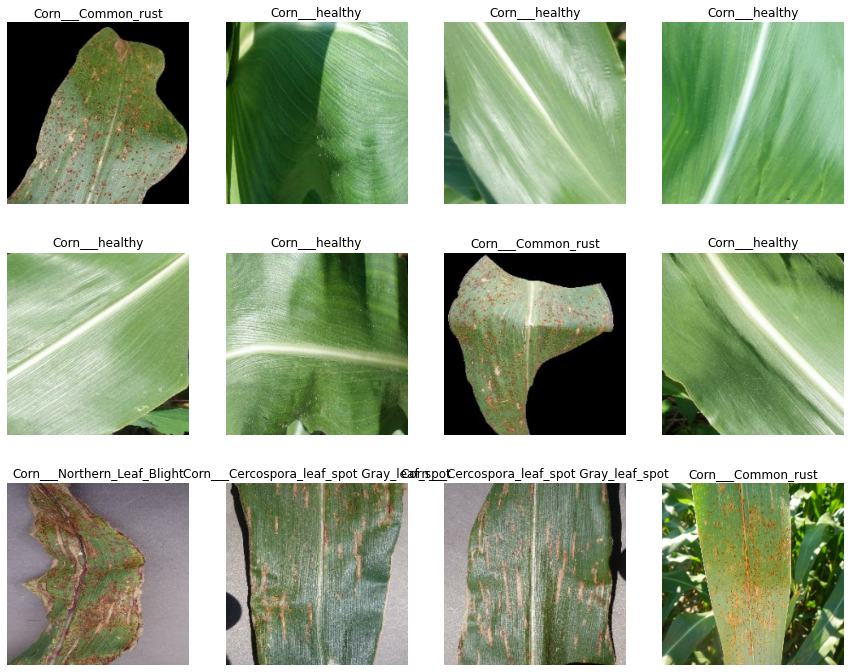

In [ ]:
plt.figure(figsize=(15, 12))
for image_batch, labels_batch in corn_train_tf.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names_corn[labels_batch[i]])
        plt.axis("off")

## Making the path to save model and checkpoints to monitor the val loss of model and saving the best model only.

In [ ]:
model_corn_path = '/content/drive/MyDrive/LDD/corn/corn_model_new.h5'
checkpoint1 = ModelCheckpoint(model_corn_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list1 = [checkpoint1] 

## Model building

In [ ]:
mobilenet = MobileNet(input_shape=[224,224,3], weights='imagenet', include_top=False)
x = Flatten()(mobilenet.output)
prediction = Dense(num_corn, activation='softmax')(x)

# create a model object
corn_modelmob = Model(inputs=mobilenet.input, outputs=prediction)

17225924/17225924 [==============================] - 0s 0us/step


## Compiling the model

In [ ]:
# tell the model what cost and optimization method to use
corn_modelmob.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  optimizer=tf.keras.optimizers.Adam(),
  metrics=['accuracy'])

## Fitting the model on the data with 20 epochs

In [ ]:
history2 = corn_modelmob.fit(
  corn_train_tf,
  validation_data = val_dataset, 
  callbacks=[callbacks_list1],
  epochs=20)

Epoch 1/20
120/120 [==============================] - ETA: 0s - loss: 1.3930 - accuracy: 0.8414
Epoch 1: val_loss improved from inf to 5.62047, saving model to /content/drive/MyDrive/LDD/corn/corn_model_new.h5
120/120 [==============================] - 502s 4s/step - loss: 1.3930 - accuracy: 0.8414 - val_loss: 5.6205 - val_accuracy: 0.8460
Epoch 2/20
119/120 [============================>.] - ETA: 0s - loss: 0.4686 - accuracy: 0.9031
Epoch 2: val_loss improved from 5.62047 to 0.36386, saving model to /content/drive/MyDrive/LDD/corn/corn_model_new.h5
120/120 [==============================] - 28s 228ms/step - loss: 0.4895 - accuracy: 0.9029 - val_loss: 0.3639 - val_accuracy: 0.9517
Epoch 3/20
119/120 [============================>.] - ETA: 0s - loss: 0.4292 - accuracy: 0.8973
Epoch 3: val_loss did not improve from 0.36386
120/120 [==============================] - 27s 219ms/step - loss: 0.4290 - accuracy: 0.8973 - val_loss: 2.3651 - val_accuracy: 0.7172
Epoch 4/20
119/120 [=============

In [ ]:
corn_modelmob.save_weights(model_corn_path)

In [ ]:
corn_modelmob.load_weights(model_corn_path)

## Evaluating the model on test dataset. Accuracy is great (87.05%)

In [ ]:
scores_corn = corn_modelmob.evaluate(test_dataset)

14/14 [==============================] - 76s 2s/step - loss: 0.4885 - accuracy: 0.8705


## Visualizing the model preformance on metrics such as loss and accuracy

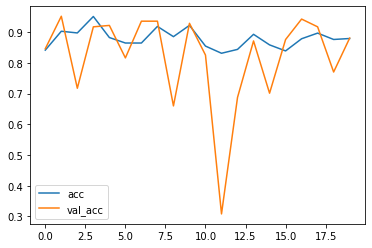

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history2.history['accuracy'], label='acc')
plt.plot(history2.history['val_accuracy'], label='val_acc')
plt.legend()

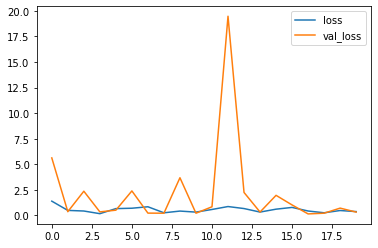

In [ ]:
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.legend()

## Making a function to Predict the image and give the confidence value

In [ ]:
def predict(corn_model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = corn_model.predict(img_array)

    predicted_class = class_names_corn[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

## Making the Function to see the model performance on images and see the confidence (Almost all are correct as accuracy is high)

1/1 [==============================] - 0s 21ms/step


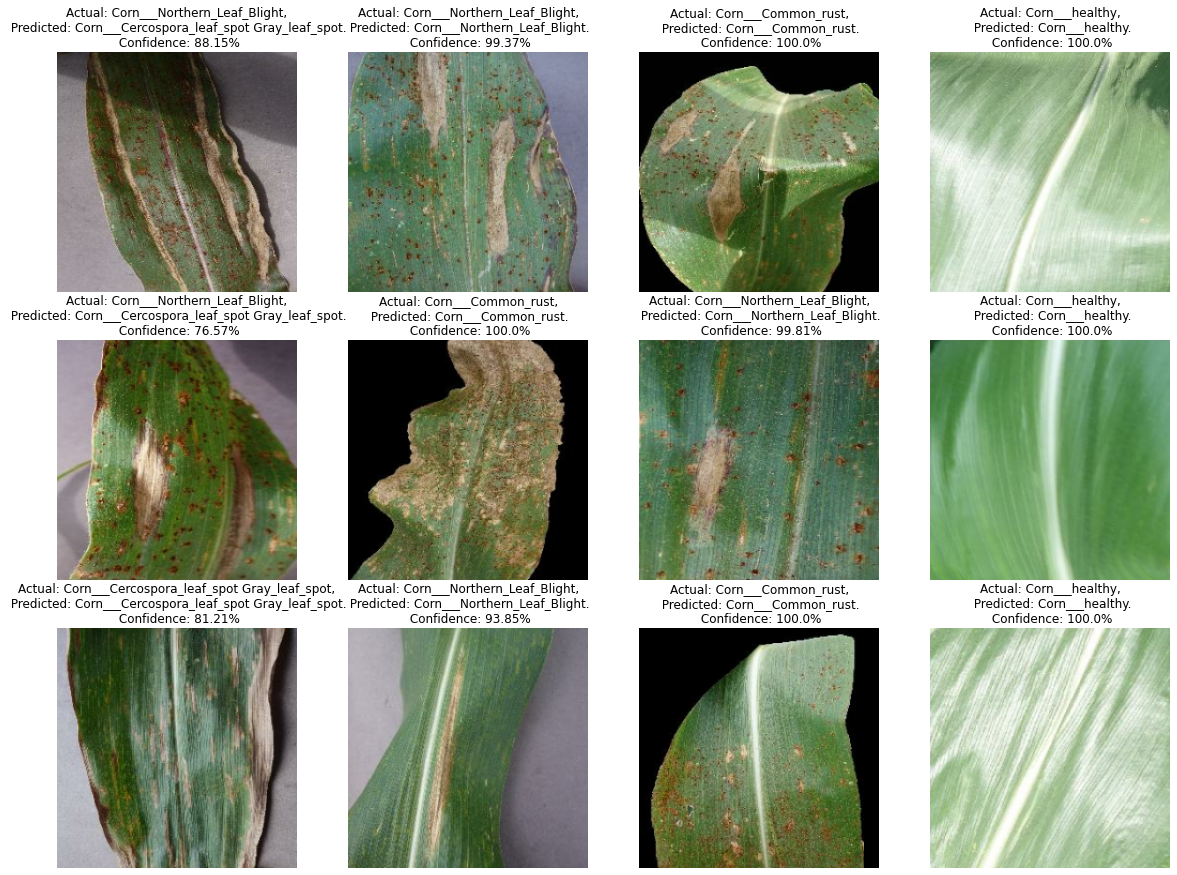

In [ ]:
plt.figure(figsize=(20, 15))
for images, labels in test_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(corn_modelmob, images[i].numpy())
        actual_class = class_names_corn[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Converting the H5 Model to Tflite format

In [ ]:
# Incase you want float point 16 Quantization, use code below.

# converter = tf.lite.TFLiteConverter.from_keras_model(corn_modelmob)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float16]
# tflite_fp16_model = converter.convert()
# with open('/content/corn_modelmob2.tflite', 'wb') as f:
#   f.write(tflite_fp16_model)


# Int 8 Quantization code
converter = tf.lite.TFLiteConverter.from_keras_model(corn_modelmob) 
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_dataset_gen():
  for img, _ in test_dataset.take(50):
    # Get sample input data as a numpy array in a method of your choosing.
    yield [img]
    
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.experimental_new_converter = True

quantized_tflite_model = converter.convert()
with open('/content/corn_int8_new.tflite', 'wb') as f:
  f.write(quantized_tflite_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [ ]:
test_images = []
test_labels = []
for image, label in test_dataset.take(len(test_dataset)).unbatch():
  test_images.append(image)
  test_labels.append(label)


## Making the function to interpret the tflite model to see it's performance

In [ ]:
def evaluate(interpreter):
  prediction= []
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  input_format = interpreter.get_output_details()[0]['dtype']
  
  for i, test_image in enumerate(test_images):
    if i % 100 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    test_image = np.expand_dims(test_image, axis=0).astype(input_format)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()
    output = interpreter.tensor(output_index)
    predicted_label = np.argmax(output()[0])
    prediction.append(predicted_label)
    
  print('\n')

  print(prediction)
  # Comparing prediction results with ground truth labels to calculate accuracy.
  prediction = np.array(prediction)
  accuracy = (prediction == test_labels).mean()
  return accuracy


## Predicting the images from test dataset from tflite model and viewing it's accuracy. It is great and Fast (accuracy = 85.68%)

In [ ]:
# Passing the int 8 TFLite model to the interpreter.
interpreter = tf.lite.Interpreter('/content/corn_int8_new.tflite')
# Allocating tensors.
interpreter.allocate_tensors()
# Evaluating the model on the test dataset.
test_accuracy = evaluate(interpreter)
print('Int 8 Quantized TFLite Model Test Accuracy:', test_accuracy*100)


Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.
Evaluated on 400 results so far.


[2, 3, 0, 1, 3, 0, 1, 3, 0, 1, 3, 0, 0, 3, 3, 0, 0, 3, 1, 0, 3, 0, 1, 0, 0, 3, 0, 3, 1, 1, 0, 1, 1, 0, 1, 3, 0, 1, 1, 1, 3, 3, 3, 1, 0, 0, 1, 1, 0, 0, 0, 3, 1, 3, 1, 0, 3, 1, 1, 3, 0, 1, 0, 2, 3, 0, 2, 0, 3, 0, 1, 3, 2, 3, 1, 0, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 0, 0, 0, 3, 1, 3, 0, 1, 0, 3, 3, 2, 1, 0, 0, 0, 0, 1, 3, 3, 3, 0, 2, 2, 3, 0, 3, 3, 3, 1, 3, 1, 1, 0, 2, 0, 1, 0, 3, 3, 1, 3, 0, 0, 0, 1, 3, 3, 1, 0, 0, 3, 2, 3, 1, 1, 1, 2, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 3, 0, 3, 3, 0, 1, 2, 2, 1, 3, 3, 1, 1, 2, 0, 0, 0, 3, 1, 0, 3, 1, 3, 0, 3, 1, 3, 3, 0, 0, 3, 1, 2, 3, 3, 3, 3, 1, 0, 0, 3, 3, 3, 0, 1, 0, 3, 1, 1, 3, 0, 1, 3, 0, 0, 3, 3, 3, 3, 3, 2, 1, 0, 1, 1, 3, 1, 0, 1, 1, 1, 0, 0, 1, 3, 0, 0, 3, 3, 0, 0, 0, 0, 1, 3, 3, 1, 2, 0, 3, 3, 2, 0, 1, 0, 2, 1, 2, 0, 0, 0, 0, 3, 2, 0, 0, 1, 0, 3, 2, 0, 0, 0, 3, 1, 1, 0, 1, 0, 

In [ ]:
import cv2
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def evaluate(interpreter, filename):
  prediction= []
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  input_format = interpreter.get_output_details()[0]['dtype']
  
  img1 = image.load_img(filename,target_size=(224,224))
  plt.imshow(img1)
  Y = image.img_to_array(img1)
  X = np.expand_dims(Y, axis=0).astype(input_format)
  interpreter.set_tensor(input_index, X)

  # Run inference.
  interpreter.invoke()
  output = interpreter.tensor(output_index)
  predicted_label = np.argmax(output()[0])
  prediction.append(predicted_label)
  
  # Check the Predicted Label on the image
  if prediction[0] == 0:
    plt.xlabel('Gray Leaf Spot',fontsize=30)
  elif prediction[0] == 1:
    plt.xlabel('Common Rust',fontsize=30)
  elif prediction[0] == 2:
    plt.xlabel('Leaf Blight',fontsize=30)
  elif prediction[0] == 3:
    plt.xlabel('Healthy',fontsize=30)

  print(f"Predicted class is: {prediction}")

  confidence = max(100 * output()[0])
  print(f"Confidence of model is: {confidence}%")
  return prediction

/content/drive/MyDrive/LDD/corn/test/Corn___healthy/image (1077).jpg
Predicted class is: [3]
Confidence of model is: 99.609375%


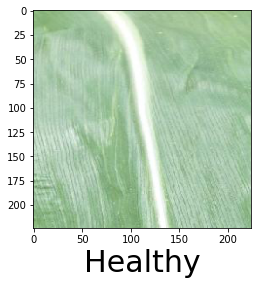

In [ ]:
# Passing the Int 8 TF Lite model to the interpreter.
interpreter = tf.lite.Interpreter('/content/corn_int8_new.tflite')
filename = input()
# Allocating tensors.
interpreter.allocate_tensors()
# Evaluating the model on the test dataset.
test_accuracy = evaluate(interpreter, filename)

## Again testing the tflite model to see the results in form of a dataframe to see if there is any bias in classes

In [ ]:

tflite_interpreter = tf.lite.Interpreter(model_path='/content/corn_int8_new.tflite')

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_input_1:0
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [1 4]
type: <class 'numpy.float32'>


In [ ]:
tflite_interpreter.resize_tensor_input(input_details[0]['index'], (32, 224, 224, 3))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (32, 5))
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_input_1:0
shape: [ 32 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [32  4]
type: <class 'numpy.float32'>


In [ ]:
test_image_batch, test_label_batch = next(iter(test_dataset))
true_label_ids = np.argmax(test_label_batch, axis=-1)

print("Test batch shape:", test_image_batch.shape)

Test batch shape: (32, 224, 224, 3)


In [ ]:
tflite_interpreter.set_tensor(input_details[0]['index'], test_image_batch)

tflite_interpreter.invoke()

tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)

Prediction results shape: (32, 4)


In [ ]:
tflite_pred_dataframe = pd.DataFrame(np.round_(tflite_model_predictions))
tflite_pred_dataframe.columns = class_names_corn

print("TFLite prediction results for the first elements")
tflite_pred_dataframe.head(50)

TFLite prediction results for the first elements


,Corn___Cercospora_leaf_spot Gray_leaf_spot,Corn___Common_rust,Corn___Northern_Leaf_Blight,Corn___healthy
0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0
5,0.0,1.0,0.0,0.0
6,0.0,1.0,0.0,0.0
7,0.0,0.0,0.0,1.0
8,0.0,1.0,0.0,0.0
9,0.0,1.0,0.0,0.0


## Dataframe shows theree is no Bias in the model and it is working perfectly fine and ready to deploy